#Linear Classifiers
This project is a part of my portfolio and cosists 2 linear classifiers (SVM, Softmax) for image classification implemnted in PyTorch, for simplicity I use CIFAR-10


## Installing module
I will continue using some functions that developed by research group of University of Michigan to help utilize PyTorch on low-level functionality: [`coutils` package](https://github.com/deepvision-class/starter-code).


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-i2dvwf96
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-i2dvwf96
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10323 sha256=a9b975cdadaa9d26ade8ba3455762fe257d6ea21410d95bb7a65c8ba698e0cb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-h5trajdt/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Importing some useful packages and increasing the default figure size.

In [ ]:
from __future__ import print_function
from __future__ import division

import torch
import coutils
import random
import time
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

I use the GPU to accelerate my computation.

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('It will be loooooooooooong LOL')

Good to go!


Now, I load CIFAR10 dataset, with normalization.


/usr/local/lib/python3.6/dist-packages/coutils/utils.py:54: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idxs = (y_data == y).nonzero().view(-1)


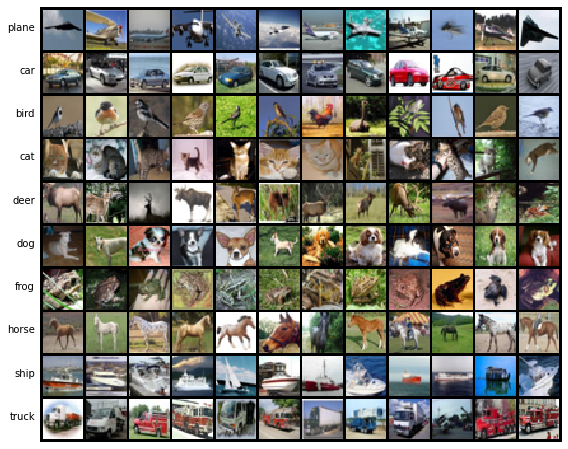

Train data shape:  torch.Size([49000, 3073])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3073])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [ ]:
def get_CIFAR10_data(validation_ratio = 0.02):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as i use for the
  SVM, but condensed to a single function.  
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Move all the data to the GPU
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Add bias dimension and transform into columns
  ones_train = torch.ones(X_train.shape[0], 1, device=X_train.device)
  X_train = torch.cat([X_train, ones_train], dim=1)
  ones_test = torch.ones(X_test.shape[0], 1, device=X_test.device)
  X_test = torch.cat([X_test, ones_test], dim=1)

  # 4. Carve out part of the training set to use for validation.
  # For random permutation, We can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # Return the dataset as a dictionary
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

# Invoke the above function to get our data.
data_dict = get_CIFAR10_data()
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

For Softmax and SVM, I analytically compute the gradients.

In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-7):
  """
  Utility function to perform numeric gradient checking. I use the centered
  difference formula to compute a numeric derivative:
  
  f'(x) =~ (f(x + h) - f(x - h)) / (2h)

  Rather than computing a full numeric gradient, I sparsely sample a few
  dimensions along which to compute numeric derivatives.

  Inputs:
  - f: A function that inputs a torch tensor and returns a torch scalar
  - x: A torch tensor giving the point at which to evaluate the numeric gradient
  - analytic_grad: A torch tensor giving the analytic gradient of f at x
  - num_checks: The number of dimensions along which to check
  - h: Step size for computing numeric derivatives
  """
  # fix random seed for 
  coutils.utils.fix_random_seed()

  for i in range(num_checks):
    
    ix = tuple([random.randrange(m) for m in x.shape])
    
    oldval = x[ix].item()
    x[ix] = oldval + h # increment by h
    fxph = f(x).item() # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x).item() # evaluate f(x - h)
    x[ix] = oldval     # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error_top = abs(grad_numerical - grad_analytic)
    rel_error_bot = (abs(grad_numerical) + abs(grad_analytic) + 1e-12)
    rel_error = rel_error_top / rel_error_bot
    msg = 'numerical: %f analytic: %f, relative error: %e'
    print(msg % (grad_numerical, grad_analytic, rel_error))

## SVM Classifier

Next I will:
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check my implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops). 

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as torch scalar
  - gradient of loss with respect to weights W; a tensor of same shape as W
  """
  dW = torch.zeros_like(W) # initialize the gradient as zero

  # computing the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = W.t().mv(X[i])
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin      

        dW[:,y[i]] = dW[:,y[i]] - X[i,:].t()
        dW[:,j] = dW[:,j] + X[i,:].t()
        
  loss /= num_train
  # Adding regularization to the loss.
  loss += reg * torch.sum(W * W)
  # Computing the gradient of the loss function and store it in dW.
  dW = dW/num_train+reg*(W*W)

  return loss, dW

Evaluating the naive implementation of the loss.

In [ ]:
# generate a random SVM weight tensor of small numbers
coutils.utils.fix_random_seed()
W = torch.randn(3073, 10, device=data_dict['X_val'].device) * 0.0001 

loss, grad = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.000433



To check that I have implemented the gradient correctly, I numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that I computed.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=0.0) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with our analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.034577 analytic: -0.034577, relative error: 2.372452e-07
numerical: 0.126951 analytic: 0.126951, relative error: 5.721190e-08
numerical: -0.068597 analytic: -0.068597, relative error: 2.249695e-07
numerical: 0.025717 analytic: 0.025717, relative error: 4.774223e-07
numerical: 0.048266 analytic: 0.048266, relative error: 2.668362e-07
numerical: 0.052260 analytic: 0.052260, relative error: 2.475153e-07
numerical: 0.096133 analytic: 0.096133, relative error: 4.690208e-09
numerical: 0.032702 analytic: 0.032702, relative error: 3.644517e-07
numerical: -0.117158 analytic: -0.117158, relative error: 4.006759e-08
numerical: -0.154093 analytic: -0.154093, relative error: 7.809949e-08


Let's do the gradient check once again with regularization turned on.


In [ ]:
# Use a minibatch of data from the val set for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with my analytically computed gradient.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.121624 analytic: -0.034575, relative error: 5.572992e-01
numerical: 0.020923 analytic: 0.126954, relative error: 7.170247e-01
numerical: -0.076604 analytic: -0.068597, relative error: 5.514632e-02
numerical: 0.256069 analytic: 0.025730, relative error: 8.173857e-01
numerical: -0.330089 analytic: 0.048301, relative error: 1.000000e+00
numerical: 0.004713 analytic: 0.052261, relative error: 8.345564e-01
numerical: 0.101968 analytic: 0.096133, relative error: 2.945453e-02
numerical: 0.097235 analytic: 0.032703, relative error: 4.966383e-01
numerical: -0.117112 analytic: -0.117158, relative error: 1.986222e-04
numerical: -0.257260 analytic: -0.154091, relative error: 2.508058e-01


Now, I implement vectorized version of SVM: `svm_loss_vectorized`. It should compute the same inputs and outputs as the naive version before, but it should involve **no explicit loops**.

In [ ]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = torch.zeros_like(W) # initialize the gradient as zero

  # Implementing a vectorized version of the structured SVM loss, storing the 
  # result in loss.                                                           
  scores = X.mm(W)
  num_train = X.shape[0]
  correct_classes_idx = (range(scores.shape[0]),y)
  correct_classes = scores[correct_classes_idx]
  margin = scores - torch.reshape(correct_classes, (-1, 1)) + 1
  margin[correct_classes_idx] = 0
  margin[margin<0] = 0
  loss = margin.sum() / num_train
  loss = loss + reg*(W*W).sum()
                                                                 
  # Implementing a vectorized version of the gradient for the structured SVM  
  # loss, storing the result in dW.                                                                                                                                                                                      
  margin[margin>0] = 1
  correct_labels_vals = torch.sum(margin,1) * -1
  margin[correct_classes_idx] = correct_labels_vals

  dW = X.t().mm(margin)
  dW/=num_train
  dW = dW + reg * 2 * W

  return loss, dW

Now I first check the speed and performance bewteen the non-vectorized and the vectorized version.


In [ ]:
# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but my vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 9.000144e+00 computed in 291.70ms
Vectorized loss: 9.000144e+00 computed in 3.64ms
Difference: -1.07e-14
Speedup: 80.09X


Next I compute the gradient of the loss function. I can check the difference of gradient as well.


In [ ]:
# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# I use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 271.85ms
Vectorized loss and gradient: computed in 3.39ms
Gradient difference: 1.75e-07
Speedup: 80.08X


Now when I have an efficient vectorized implementation of the SVM loss and its gradient, I can implement a training pipeline for linear classifiers.



In [ ]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  """
  Train this linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss function to use when training. It should take W, X, y
    and reg as input, and output a tuple of (loss, dW)
  - W: A PyTorch tensor of shape (D, C) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c
    means that X[i] has label 0 <= c < C for C classes.
  - learning_rate: (float) learning rate for optimization.
  - reg: (float) regularization strength.
  - num_iters: (integer) number of steps to take when optimizing
  - batch_size: (integer) number of training examples to use at each step.
  - verbose: (boolean) If true, print progress during optimization.

  Returns: A tuple of:
  - W: The final value of the weight matrix and the end of optimization
  - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
  """
  # assume y takes values 0...K-1 where K is number of classes
  num_classes = torch.max(y) + 1
  num_train, dim = X.shape
  if W is None:
    # lazily initialize W
    W = 0.000001 * torch.randn(dim, num_classes, device=X.device, dtype=X.dtype)

  # Running stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    # Sampling batch_size elements from the training data and their         
    # corresponding labels to use in this round of gradient descent.        
    # Storing the data in X_batch and their corresponding labels in         
    # y_batch; after sampling, X_batch should have shape (batch_size, dim)  
    # and y_batch should have shape (batch_size,)                           

    #Using torch.randint to generate indices.
    batch_idxes = torch.randint(num_train, (batch_size,))
    X_batch = X[batch_idxes, :]
    y_batch = y[batch_idxes]

    # evaluating loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # performing parameter update
    # Updating the weights using the gradient and the learning rate.
    W += - grad * learning_rate 

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

I implemented the training function, now I train a linear classifier using some default hyperparameters:


In [ ]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed()

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 9.000759
iteration 100 / 1500: loss 9.000790
iteration 200 / 1500: loss 9.000771
iteration 300 / 1500: loss 9.000764
iteration 400 / 1500: loss 9.000766
iteration 500 / 1500: loss 9.000767
iteration 600 / 1500: loss 9.000770
iteration 700 / 1500: loss 9.000748
iteration 800 / 1500: loss 9.000766
iteration 900 / 1500: loss 9.000761
iteration 1000 / 1500: loss 9.000764
iteration 1100 / 1500: loss 9.000766
iteration 1200 / 1500: loss 9.000779
iteration 1300 / 1500: loss 9.000757
iteration 1400 / 1500: loss 9.000749
That took 1.383834s


My favourite debugging strategy is to plot the loss as a function of iteration number. In this case it seems my hyperparameters are not good, since the training loss is not decreasing very fast.



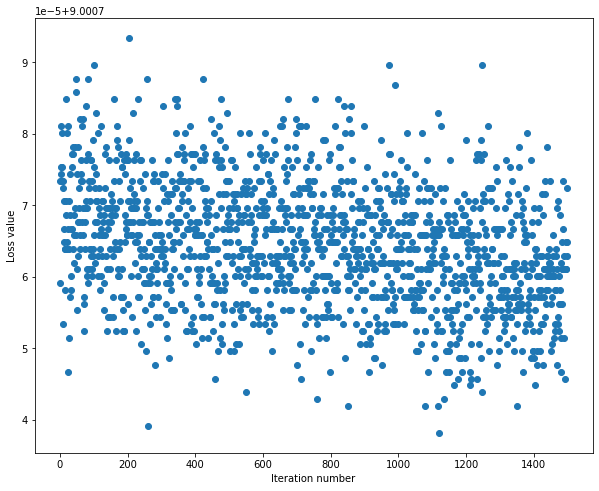

In [ ]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's move on to the prediction stage:

In [ ]:
def predict_linear_classifier(W, X):
  """
  Inputs:
  - W: A PyTorch tensor of shape (D, C), containing weights of a model
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.

  Returns:
  - y_pred: PyTorch int64 tensor of shape (N,) giving predicted labels for each
    elemment of X. Each element of y_pred should be between 0 and C - 1.
  """
  y_pred = torch.zeros(X.shape[0])
  # Implementing this method. Storing the predicted labels in y_pred.
  y_pred = X.mm(W)
  y_pred = torch.argmax(y_pred,1)

  return y_pred

Now I evaluate the performance my trained model on both the training and validation set.

In [ ]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('Training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 10.24%
Validation accuracy: 10.20%


Unfortunately, the performance of my initial model is quite bad, Now I will fix it

In [ ]:
class LinearClassifier(object):
  
  def __init__(self):
    self.W = None
    
  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X) 
  
  def loss(self, W, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.
    """
    pass
  def _loss(self, X_batch, y_batch, reg):
    self.loss(self.W, X_batch, y_batch, reg)

  
class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, W, X_batch, y_batch, reg):
    return svm_loss_vectorized(W, X_batch, y_batch, reg)

Now, I use the validation set to tune hyperparameters (regularization strength and learning rate). I will experiment with different ranges for the learning rates and regularization strengths.

(My best model got over 40%)

In [ ]:
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
learning_rates = [1e-3, 1e-2] # learning rate candidates, e.g. [1e-3, 1e-2, ...]
regularization_strengths = [ 1e-2, 1e-3] # regularization strengths candidates e.g. [1e0, 1e1, ...]

grid_search = [(lr,reg) for lr in learning_rates for reg in regularization_strengths]
X_train=data_dict['X_train']
y_train=data_dict['y_train']
X_val=data_dict['X_val']
y_val=data_dict['y_val']
for lr, reg in grid_search:
    # Create a new SVM instance
    model = LinearSVM()
    # Train the model with current parameters
    train_loss = model.train(X_train,y_train,lr,reg,num_iters=5000,batch_size=128,verbose=False)
    y_train_pred = model.predict(X_train)
    train_acc = 100.0 * torch.mean((y_train_pred == y_train).float())
    y_val_pred = model.predict(X_val)
    val_acc = 100.0 * torch.mean((y_val_pred == y_val).float())
    results[(lr,reg)] = (train_acc,val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_svm = model
    
# Print out results.
for lr, reg in sorted(results):
  train_accuracy, val_accuracy = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-03 reg 1.000000e-03 train accuracy: 39.963264 val accuracy: 39.200001
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 39.781631 val accuracy: 39.900002
lr 1.000000e-02 reg 1.000000e-03 train accuracy: 41.175507 val accuracy: 39.700001
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 41.340816 val accuracy: 39.100002
best validation accuracy achieved during cross-validation: 39.900002


Visualize the cross-validation results. I can use this as a debugging tool -- after examining the cross-validation results here.

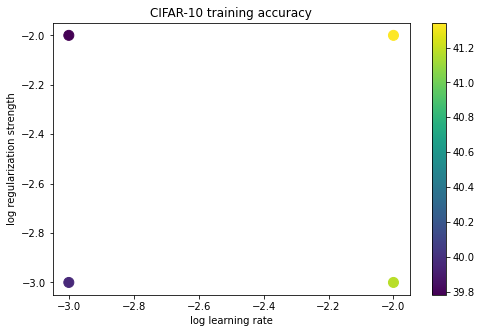

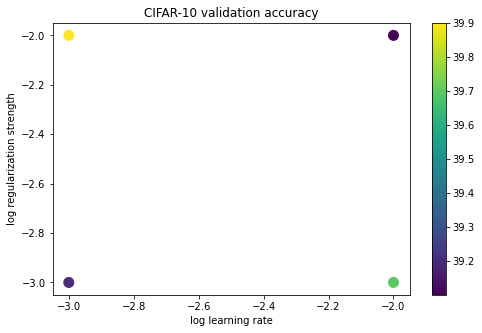

In [ ]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Evaluate the best svm on test set.

(My best here was over 38%)

In [ ]:
y_test_pred = best_svm.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.389600


Visualize the learned weights for each class.

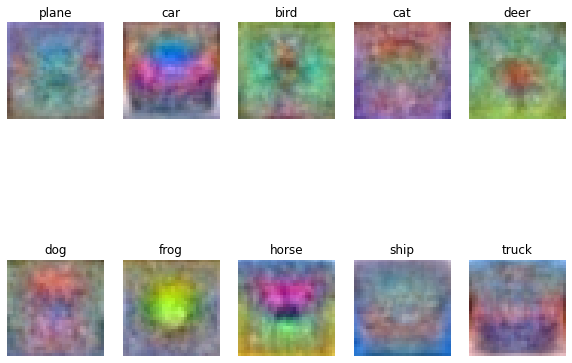

In [ ]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

## Softmax Classifier

Similar to the SVM, I will:

- implementing a fully-vectorized **loss function** for the Softmax classifier
- implementing the fully-vectorized expression for its **analytic gradient**
- **checking implementation** with numerical gradient
- using a validation set to **tune the learning rate and regularization** strength
- **optimizing** the loss function with **SGD**
- **visualizing** the final learned weights

First, I will start from implementing the naive softmax loss function with nested loops.


In [ ]:
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops).
  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an tensor of same shape as W
  """
  # Initializing the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)
  # Getting shapes
  num_train = X.shape[0]
  num_classes = W.shape[1]
  # Forward propagation
  pred = X.mm(W)
  # Setting largest value to zero for numeric stability
  max_score = torch.max(pred,dim=1)[0].reshape(-1,1)
  pred -= max_score
  # Softmax activation and cross entropy loss
  for i in range(num_train):
      exp_loss = 0.0
      for j in range(num_classes):
        exp_loss += torch.exp(pred[i,j])
        loss_i = -1 * pred[i,y[i]] + torch.log(exp_loss) 
        loss += loss_i
  # Backpropogation
      for j in range(num_classes):
          dW[:,j] += (1/exp_loss) * torch.exp(pred[i,j]) * X[i]
          if j == y[i]:
            dW[:,j] -= X[i]
  # Averaging over batch      
  loss/= num_train
  dW/= num_train
  # L2 regularization for loss and gradients
  loss += reg * torch.sum(W*W)
  dW += reg*2*W

  return loss, dW

As a sanity check to see whether the implemention of the loss correctly, I am running the softmax classifier with a small random weight matrix and no regularization.

In [ ]:
# Generating a random softmax weight tensor and using it to compute the loss.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

# Compleing the implementation of softmax_loss_naive and implementing a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 15.104510
sanity check: 2.302585


Next, using gradient checking to debug the analytic gradient of naive softmax loss function.


In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.080913 analytic: 0.008387, relative error: 8.121595e-01
numerical: 0.093662 analytic: 0.009227, relative error: 8.206365e-01
numerical: -0.083336 analytic: -0.002471, relative error: 9.424073e-01
numerical: -0.027895 analytic: -0.003144, relative error: 7.974113e-01
numerical: 0.050591 analytic: 0.006011, relative error: 7.876006e-01
numerical: 0.061329 analytic: 0.005936, relative error: 8.235118e-01
numerical: 0.208602 analytic: 0.015703, relative error: 8.599822e-01
numerical: 0.076393 analytic: 0.006452, relative error: 8.442371e-01
numerical: -0.159704 analytic: -0.015533, relative error: 8.227210e-01
numerical: -0.177736 analytic: -0.010170, relative error: 8.917571e-01


Next I perform another gradient check with regularization enabled.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
reg = 10.0

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.080043 analytic: 0.007517, relative error: 8.283078e-01
numerical: 0.092602 analytic: 0.008167, relative error: 8.379059e-01
numerical: -0.083416 analytic: -0.002551, relative error: 9.406517e-01
numerical: -0.025591 analytic: -0.000841, relative error: 9.363989e-01
numerical: 0.046807 analytic: 0.002228, relative error: 9.091444e-01
numerical: 0.060854 analytic: 0.005460, relative error: 8.353209e-01
numerical: 0.208660 analytic: 0.015762, relative error: 8.595351e-01
numerical: 0.077038 analytic: 0.007097, relative error: 8.312862e-01
numerical: -0.159704 analytic: -0.015532, relative error: 8.227254e-01
numerical: -0.178767 analytic: -0.011201, relative error: 8.820714e-01


Then, I move on to the vectorized form

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initializing the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)

  # Getting shapes
  num_train = X.shape[0]
  num_classes = W.shape[1]
  # Forward propagation
  pred = X.mm(W)
  # Subtraction max to make max value = 0 for numerical stability
  max_pred = torch.max(pred,dim=1)[0].reshape(-1,1)
  pred -= max_pred
  # Softmax activation
  exp_score = torch.exp(pred)
  denominator = torch.sum(exp_score,dim=1)
  numerator = exp_score[range(num_train),y]
  # Cross entropy loss
  loss = -1 * torch.log(numerator/denominator).sum()
  # Backpropogation
  correct_classes = torch.zeros((num_train, num_classes),dtype=X.dtype).cuda()
  correct_classes[range(num_train),y] =- 1
  dW_term1 = X.t().mm(correct_classes)
  dW_term2 = (X.t() / denominator).mm(exp_score)
  dW = dW_term1 + dW_term2
  # Averaging over batch
  loss/=num_train
  dW/=num_train
  # L2 regularization for loss and gradients
  loss += reg * torch.sum(W*W)
  dW += reg * 2 * W

  return loss, dW

Now I have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

In [ ]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 1.510453e+01 computed in 294.046402s
vectorized loss: 2.302616e+00 computed in 1.281261s
Loss difference: 1.28e+01
Gradient difference: 3.26e-07
Speedup: 229.50X


Now I check that implementation of the softmax loss is numerically stable.


In [ ]:
device = data_dict['X_train'].device
dtype = torch.float32
D = data_dict['X_train'].shape[1]
C = 10

W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


iteration 0 / 1: loss 768249984.000000
iteration 0 / 1: loss 768249984.000000


Eventually I train a softmax classifier with some default hyperparameters:


In [ ]:
# fixing random seed before we perform this operation
coutils.utils.fix_random_seed(10)

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.303346
iteration 100 / 1500: loss 2.303344
iteration 200 / 1500: loss 2.303344
iteration 300 / 1500: loss 2.303342
iteration 400 / 1500: loss 2.303342
iteration 500 / 1500: loss 2.303342
iteration 600 / 1500: loss 2.303342
iteration 700 / 1500: loss 2.303341
iteration 800 / 1500: loss 2.303338
iteration 900 / 1500: loss 2.303339
iteration 1000 / 1500: loss 2.303339
iteration 1100 / 1500: loss 2.303336
iteration 1200 / 1500: loss 2.303335
iteration 1300 / 1500: loss 2.303337
iteration 1400 / 1500: loss 2.303334
That took 1.082562s


Plot the loss curve:

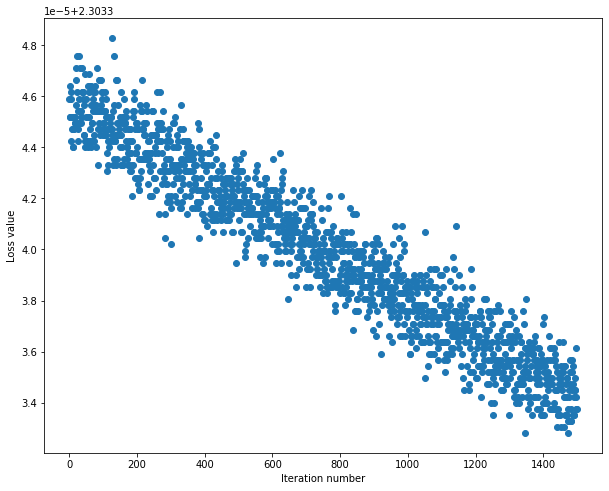

In [ ]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Checking the accuracy of current model.

In [ ]:
# evaluating the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.43%
validation accuracy: 8.00%


I am using the validation set to tune hyperparameters (regularization strength and learning rate). Experimenting with different ranges for the learning rates and regularization strengths.


In [ ]:
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """
  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)

In [ ]:
results = {}
best_val = -1
best_softmax = None

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4] # learning rate candidates
regularization_strengths = [1e-1, 1e-2, 1e-3] # regularization strengths candidates

# As before, storing cross-validation results in this dictionary.
# The keys are tuples of (learning_rate, regularization_strength) and
# the values are tuples (train_accuracy, val_accuracy)
results = {}
# Saving best trained softmax classifer in best_softmax.                                                
grid_search = [(lr,reg) for lr in learning_rates for reg in regularization_strengths]
X_train = data_dict['X_train'].double()
y_train = data_dict['y_train']
X_val = data_dict['X_val'].double()
y_val = data_dict['y_val']
for lr,reg in grid_search:
    model = Softmax()
    train_loss = model.train(X_train,y_train,lr,reg,num_iters=1500,batch_size=64,verbose=False)
    y_pred_train = model.predict(X_train)
    train_acc = torch.mean((y_pred_train == y_train).float()) * 100.0
    y_pred_val = model.predict(X_val)
    val_acc = torch.mean((y_pred_val == y_val).float()) * 100.0
    results[(lr,reg)] = (train_acc,val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_softmax = model

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-04 reg 1.000000e-03 train accuracy: 25.700001 val accuracy: 27.100002
lr 1.000000e-04 reg 1.000000e-02 train accuracy: 25.991837 val accuracy: 27.200001
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 25.873466 val accuracy: 26.800001
lr 1.000000e-03 reg 1.000000e-03 train accuracy: 32.955101 val accuracy: 33.800003
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 32.873470 val accuracy: 33.100002
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 32.169388 val accuracy: 32.900002
lr 1.000000e-02 reg 1.000000e-03 train accuracy: 39.269386 val accuracy: 39.500000
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 39.130611 val accuracy: 39.900002
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 36.869385 val accuracy: 37.000000
lr 1.000000e-01 reg 1.000000e-03 train accuracy: 40.526531 val accuracy: 39.500000
lr 1.000000e-01 reg 1.000000e-02 train accuracy: 38.461224 val accuracy: 38.300003
lr 1.000000e-01 reg 1.000000e-01 train accuracy: 33.359180 val accuracy: 34.500004
best

Visualizing cross-validation results:

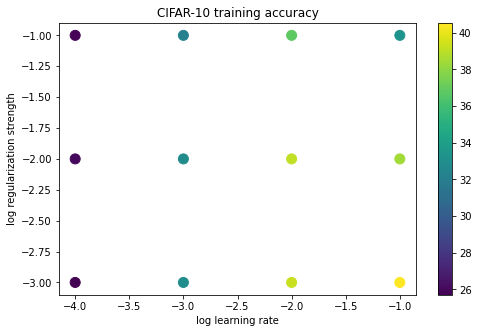

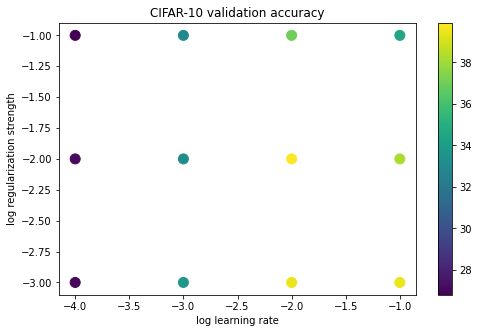

In [ ]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Evaluating the performance of my best model on test set.



In [ ]:
y_test_pred = best_softmax.predict(data_dict['X_test'].double())
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.385200


Finally, let's visualize the learned weights for each class

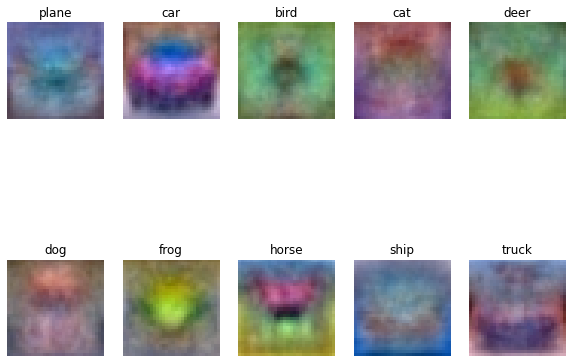

In [ ]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])